<a href="https://colab.research.google.com/github/SangJunPark1/Obstacle-Course/blob/master/201711907_%EB%B0%95%EC%83%81%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제1

## 데이터

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/ralbu85/AI_student/master/OnlineNewsPopularity.csv")
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,671.0,173.125,26900.0,843300.0,374962.500000,2514.742857,4004.342857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,

In [ ]:
# 전체적인 데이터 파악
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,0.052946,0.178009,0.157855,0.058597,0.185299,0.212567,26.106801,1153.951682,312.366967,13612.354102,752324.066694,259281.938083,1117.146610,5657.211151,3135.858639,3998.755396,10329.212662,6401.697580,0.168020,0.186409,0.187544,0.183306,0.143805,0.061876,0.069039,0.130915,0.184599,0.141256,0.216321,0.223770,0.234029,0.443370,0.119309,0.039625,0.016612,0.682150,0.287934,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,0.223929,0.382525,0.364610,0.234871,0.388545,0.409129,69.633215,3857.990877,620.783887,57986.029357,214502.129573,135102.247285,1137.456951,6098.871957,1318.150397,19738.670516,41027.576613,24211.332231,0.373889,0.389441,0.390353,0.386922,0.350896,0.240933,0.253524,0.337312,0.262975,0.219707,0.282145,0.295191,0.289183,0.116685,0.096931,0.017429,0.010828,0.190206,0.156156,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,141.750000,0.000000,843300.000000,172846.875000,0.000000,3562.101631,2382.448566,639.000000,1100.000000,981.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025051,0.025012,0.028571,0.028571,0.0

In [ ]:
# 이상치 제거 함수 정의
def outlier_detection(df,colname) : 
    df[colname]
    q1=df[colname].quantile(0.25)
    q3=df[colname].quantile(0.75)
    iqr=q3-q1
    condition1=df[colname] > q3+1.5*iqr  
    condition2=df[colname] < q1-1.5*iqr


    a = df[condition1].index
    b = df[condition2].index
    a = a.append(b)
    df.drop(a,inplace=True)
    print(f'total {len(a)} outlier deleted.')

In [ ]:
# 특정피처의 이상치 제거 
outlier_detection(df,' shares')

total 4541 outlier deleted.


## 독립/종속변수 나누기

In [ ]:
# 종속변수
y = df.pop(' shares')
y

0         593
1         711
2        1500
3        1200
4         505
         ... 
39639    1800
39640    1900
39641    1900
39642    1100
39643    1300
Name:  shares, Length: 35103, dtype: int64

In [ ]:
# 독립변수
X=df.drop(columns='url',axis=1)
X

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,671.0,173.125,26900.0,843300.0,374962.500000,2514.742857,4004.342857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,7.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,616.0,184.000,6500.0,843300.0,192985.714286,1664.267857,5470.168651,3411.660830,2100.0,2100.0,2100.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.029349,0.028575,0.231866,0.681635,0.028575,0.564374,0.194249,0.039634,0.009146,0.812500,0

## 표준화

In [ ]:
# 정규화 진행
X_std = (X-X.mean())/X.std()

In [ ]:
# 모양확인 
X_std.shape                    

(35103, 59)

In [ ]:
# 계산을 위해 numpy 사용 
import numpy as np
X_std = np.array(X_std,dtype=float)
y = np.array(y,dtype=float)

In [ ]:
# pca(주성분 분석)
from sklearn.decomposition import PCA
pca = PCA(n_components=15) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10','PC11', 'PC12', 'PC13', 'PC14', 'PC15'])
# 주성분으로 이루어진 데이터 프레임 구성(주성분 15개)

In [ ]:
# 데이터 확인 
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-2.043498,-1.535494,-2.105886,-0.437148,1.145296,-3.635909,-0.629698,1.718766,0.362650,0.476995,0.950342,1.718430,0.115856,0.967772,0.357528
1,-0.543704,-3.871667,-2.552870,-1.672689,0.290624,-1.448275,2.203878,2.910789,0.337021,-0.504288,-0.094585,0.659846,-0.846471,-0.634638,0.282016
2,-3.523883,-3.369200,-1.686615,0.188673,0.019752,-1.023716,0.865117,1.924837,-0.785329,-0.166136,-0.114687,0.171770,1.420643,-0.064464,-0.638446
3,-0.942817,-0.991443,-3.349566,0.813761,1.505334,-2.195278,-0.131278,1.634406,-1.153858,-0.077288,2.022308,0.799299,0.013479,0.487839,0.108214
4,-2.486194,-3.785139,-0.346395,5.125159,-1.010992,-0.247239,-1.159579,1.511215,-0.650988,1.421519,-1.098129,-0.119236,-1.119633,0.897057,0.653861


In [ ]:
# train data, test data로 나누기(8대 2) 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.2, random_state=777)

## 회귀모형


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# 손실함수에서 사용할 RMSE 함수 정의 
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
# callback 정의 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
# 모델 정의 
def build_model():
    model = keras.Sequential([
                              layers.Dense(1024, input_shape=[x_train.shape[1]], activation='relu'),
                              layers.Dense(516, activation='relu'),
                              layers.Dense(256, activation='relu'),
                              layers.Dense(256, activation='relu'),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(10, activation='relu'),
                              layers.Dense(1)  
    ])

    optimizer = keras.optimizers.Adam(0.01) # 경사하강법 사용 
    model.compile(loss=rmse,optimizer=optimizer,metrics=rmse)
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              16384     
                                                                 
 dense_1 (Dense)             (None, 516)               528900    
                                                                 
 dense_2 (Dense)             (None, 256)               132352    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 10)                1

## 모델 학습

In [ ]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test,y_test),callbacks=[early_stop])

Epoch 1/1000
878/878 [==============================] - 22s 22ms/step - loss: 804.1118 - rmse: 804.1118 - val_loss: 764.2319 - val_rmse: 764.2319
Epoch 2/1000
878/878 [==============================] - 17s 20ms/step - loss: 766.9802 - rmse: 766.9802 - val_loss: 783.2557 - val_rmse: 783.2557
Epoch 3/1000
878/878 [==============================] - 13s 14ms/step - loss: 750.5958 - rmse: 750.5958 - val_loss: 741.4687 - val_rmse: 741.4687
Epoch 4/1000
878/878 [==============================] - 12s 13ms/step - loss: 745.7842 - rmse: 745.7842 - val_loss: 746.5906 - val_rmse: 746.5906
Epoch 5/1000
878/878 [==============================] - 13s 14ms/step - loss: 743.6591 - rmse: 743.6591 - val_loss: 724.2100 - val_rmse: 724.2100
Epoch 6/1000
878/878 [==============================] - 12s 14ms/step - loss: 741.0580 - rmse: 741.0580 - val_loss: 731.5027 - val_rmse: 731.5027
Epoch 7/1000
878/878 [==============================] - 12s 14ms/step - loss: 735.0929 - rmse: 735.0929 - val_loss: 733.6714

In [ ]:
hist = history.history
hist.keys()

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])

## 그래프로 확인해보기

In [ ]:
import matplotlib.pyplot as plt

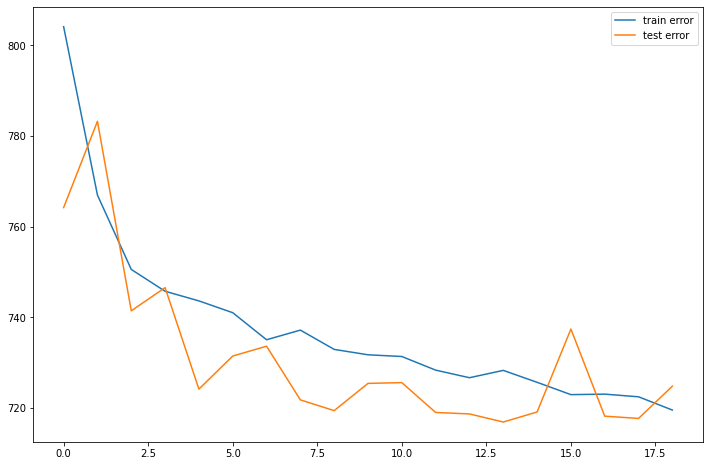

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist['loss'], label='train error')
plt.plot(hist['val_loss'], label='test error')
plt.legend()

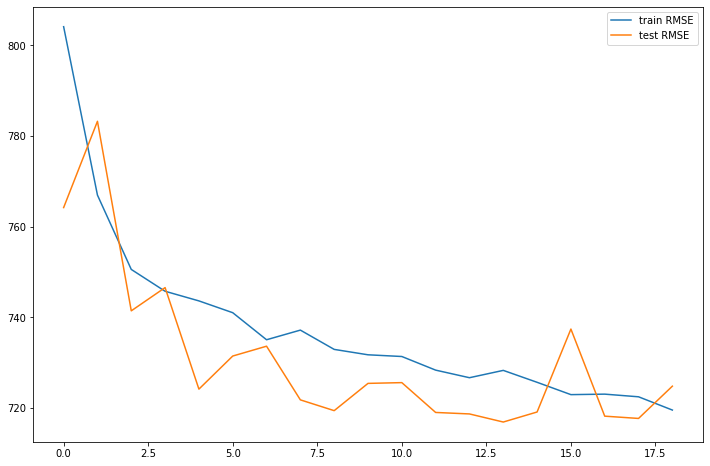

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist['rmse'], label='train RMSE')
plt.plot(hist['val_rmse'], label='test RMSE')
plt.legend()

# 과제2

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/ralbu85/AI_student/master/OnlineNewsPopularity.csv")
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,671.0,173.125,26900.0,843300.0,374962.500000,2514.742857,4004.342857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,

## 전처리 

In [ ]:
# 결측치 확인 
df.isnull().sum()

url                              0
 timedelta                       0
 n_tokens_title                  0
 n_tokens_content                0
 n_unique_tokens                 0
                                ..
 title_subjectivity              0
 title_sentiment_polarity        0
 abs_title_subjectivity          0
 abs_title_sentiment_polarity    0
 shares                          0
Length: 61, dtype: int64

## 독립/종속 변수

In [ ]:
y = df.pop(' shares')
y

0         593
1         711
2        1500
3        1200
4         505
         ... 
39639    1800
39640    1900
39641    1900
39642    1100
39643    1300
Name:  shares, Length: 39644, dtype: int64

In [ ]:
X=df.drop(columns='url',axis=1)
X

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,671.0,173.125,26900.0,843300.0,374962.500000,2514.742857,4004.342857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,7.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,616.0,184.000,6500.0,843300.0,192985.714286,1664.267857,5470.168651,3411.660830,2100.0,2100.0,2100.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.029349,0.028575,0.231866,0.681635,0.028575,0.564374,0.194249,0.039634,0.009146,0.812500,0

## 표준화

In [ ]:
X_std = (X-X.mean())/X.std()

In [ ]:
X_std.shape

(39644, 59)

In [ ]:
import numpy as np
X_std = np.array(X_std,dtype=float)
y = np.array(y,dtype=float)

In [ ]:
# train data, test data로 나누기(8대 2) 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=777)

In [ ]:
# class 1 : 0  / class 2 : 1 로 클래스 나누기
y_train[y_train<=1400] = 0
y_train[y_train>1400] = 1

y_test[y_test<=1400] = 0
y_test[y_test>1400] = 1

## 분류모델 

In [ ]:
# 모델 정의 
def build_model():
  model = tf.keras.Sequential([
                            layers.Dense(60,input_shape=[x_train.shape[1]],activation='relu'),
                            layers.Dense(256,activation='relu'),
                            layers.Dense(256,activation='relu'),
                            layers.Dense(1,activation='sigmoid')   # 0~1사이의 확률을 갖도록
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
model1 = build_model()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 60)                3600      
                                                                 
 dense_13 (Dense)            (None, 256)               15616     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 85,265
Trainable params: 85,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(x_train, y_train, epochs=1000, validation_data=(x_test,y_test),callbacks=[early_stop])

Epoch 1/1000
992/992 [==============================] - 4s 4ms/step - loss: 0.6390 - accuracy: 0.6377 - val_loss: 0.6150 - val_accuracy: 0.6631
Epoch 2/1000
992/992 [==============================] - 3s 3ms/step - loss: 0.6189 - accuracy: 0.6571 - val_loss: 0.6157 - val_accuracy: 0.6586
Epoch 3/1000
992/992 [==============================] - 4s 4ms/step - loss: 0.6108 - accuracy: 0.6636 - val_loss: 0.6135 - val_accuracy: 0.6605
Epoch 4/1000
992/992 [==============================] - 4s 4ms/step - loss: 0.6047 - accuracy: 0.6672 - val_loss: 0.6134 - val_accuracy: 0.6601
Epoch 5/1000
992/992 [==============================] - 3s 3ms/step - loss: 0.5979 - accuracy: 0.6725 - val_loss: 0.6082 - val_accuracy: 0.6658
Epoch 6/1000
992/992 [==============================] - 3s 3ms/step - loss: 0.5899 - accuracy: 0.6778 - val_loss: 0.6083 - val_accuracy: 0.6650
Epoch 7/1000
992/992 [==============================] - 4s 4ms/step - loss: 0.5802 - accuracy: 0.6868 - val_loss: 0.6190 - val_accuracy:

In [ ]:
history = history.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 그래프로 확인하기

In [ ]:
import matplotlib.pyplot as plt

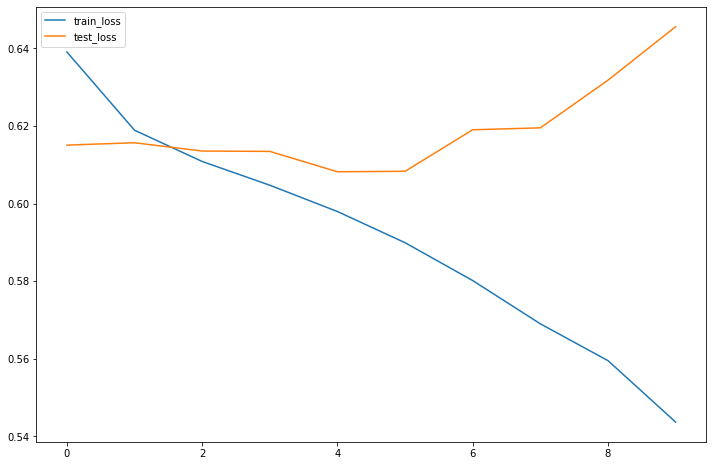

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='test_loss')
plt.legend()

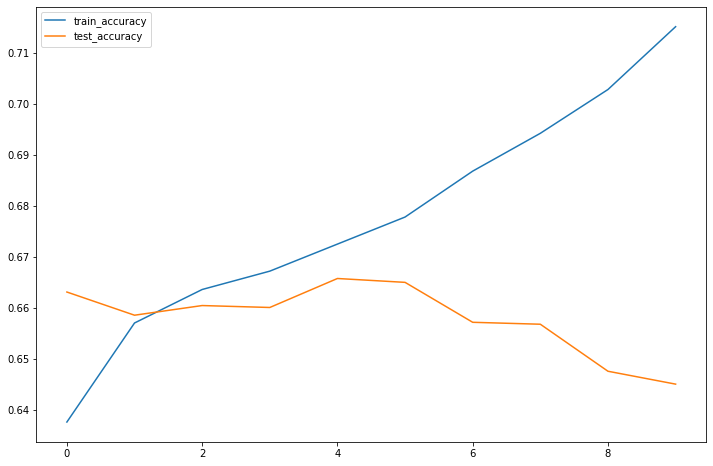

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='test_accuracy')
plt.legend()

# 최종정리
### 과제1(회귀모형)
과제1에서 기존 제공 데이터로 모델을 학습하면 rmse값이 너무 커져서 기존 데이터에서 이상치를 전부 제거했더니 데이터의 양이 너무 작아져 y의 이상치만 제거한 후 주성분 분석(PCA)를 사용하여 모델의 정확도를 높였습니다. 그래서 최종 rmse값은 804.1118에서 719.5942로 감소하여 학습하였습니다. 또한 그래프를 보시면 잘 학습이 되는 것을 알 수 있습니다. 
### 과제2(분류모형)
과제2에서는 기존 제공 데이터로 accuracy를 구해도 0.7이상의 값을 얻었기 때문에 그대로 진행하였습니다. 그래서 모델을 학습하면 accuracy값은 0.6377에서 0.7151로 증가하였으며 그래프에서도 학습이 어느 정도 되고 있다는 사실을 알 수 있습니다.
